In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
from scipy.stats import entropy
import copy
import math
from environments import SBEOS_Environment

time_dependence = 3
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transition tuple for experience replay
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'done', 'priority'))

# Add standard ReplayBuffer class that was missing
class ReplayBuffer:
    """Standard experience replay buffer"""
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity
        
    def push(self, *args):
        """Save a transition"""
        # Add a dummy priority of 1.0 to match the Transition namedtuple
        self.memory.append(Transition(*args, priority=1.0))
        
    def sample(self, batch_size):
        """Sample a batch of transitions randomly"""
        if len(self.memory) < batch_size:
            return []
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class PrioritizedReplayBuffer:
    """Prioritized experience replay buffer for more efficient learning"""
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity
        self.alpha = alpha             # How much prioritization to use (0 = no prioritization, 1 = full prioritization)
        self.beta = beta_start         # Importance sampling correction factor
        self.beta_frames = beta_frames # Number of frames over which to anneal beta to 1
        self.frame = 1                 # Current frame counter
        self.epsilon = 1e-6            # Small constant to ensure all priorities > 0
        
    def push(self, *args):
        """Save a transition with max priority on first insertion"""
        # If memory is not empty, use max priority; otherwise use 1.0
        max_priority = max([t.priority for t in self.memory]) if self.memory else 1.0
        self.memory.append(Transition(*args, priority=max_priority))
        
    def sample(self, batch_size):
        """Sample a batch of transitions with prioritization"""
        if len(self.memory) < batch_size:
            return [], [], []
        
        # Calculate selection probabilities based on priorities
        priorities = np.array([t.priority for t in self.memory])
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Update beta
        self.beta = min(1.0, self.beta + self.frame * (1.0 - self.beta) / self.beta_frames)
        self.frame += 1
        
        # Sample using the probabilities
        indices = np.random.choice(len(self.memory), batch_size, p=probs, replace=False)
        samples = [self.memory[idx] for idx in indices]
        
        # Calculate importance sampling weights
        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize weights
        weights = torch.FloatTensor(weights).to(device)
        
        return samples, indices, weights
    
    def update_priorities(self, indices, priorities):
        """Update priorities for sampled transitions"""
        for idx, priority in zip(indices, priorities):
            if 0 <= idx < len(self.memory):  # Ensure index is valid
                self.memory[idx] = self.memory[idx]._replace(priority=priority.item() + self.epsilon)
    
    def __len__(self):
        return len(self.memory)

class DuelingDQN(nn.Module):
    """Improved Dueling DQN architecture with separate value and advantage streams"""
    def __init__(self, state_size, action_size, hidden_dim=256):
        super(DuelingDQN, self).__init__()
        
        # Feature extraction layers with batch normalization for stability
        self.feature_layers = nn.Sequential(
            nn.Linear(state_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        # Value stream (estimates state value)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Advantage stream (estimates action advantages)
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_size)
        )
        
        # Initialize weights with improved method
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize network weights with Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
                    
    def forward(self, x):
        # Extract features
        features = self.feature_layers(x)
        
        # Get value and advantages
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Combine value and advantages using dueling architecture formula with improved numerical stability
        return value + (advantages - advantages.mean(dim=1, keepdim=True))

class ImprovedDuelingDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        memory_size=50000,
        batch_size=128,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=50000,
        learning_rate=0.0001,
        target_update_freq=1000,   # Hard update frequency (steps)
        use_soft_update=True,      # Whether to use soft updates
        tau=0.005,                 # Soft update parameter
        double_dqn=True,           # Whether to use Double DQN algorithm
        prioritized_replay=True,   # Whether to use prioritized experience replay
        n_step=3,                  # N-step returns
        reward_clip=None,          # Optional reward clipping
        adam_eps=1e-8              # Adam epsilon for numerical stability
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.target_update_freq = target_update_freq
        self.use_soft_update = use_soft_update
        self.tau = tau
        self.double_dqn = double_dqn
        self.prioritized_replay = prioritized_replay
        self.n_step = n_step
        self.reward_clip = reward_clip
        self.steps_done = 0
        self.update_counter = 0
        
        # N-step transition buffer
        self.n_step_buffer = deque(maxlen=n_step)
        
        # Initialize replay buffer
        if prioritized_replay:
            self.memory = PrioritizedReplayBuffer(memory_size)
        else:
            self.memory = ReplayBuffer(memory_size)
        
        # Initialize networks
        self.policy_net = DuelingDQN(state_size, action_size).to(device)
        self.target_net = DuelingDQN(state_size, action_size).to(device)
        
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        # Optimizer with weight decay for regularization and improved numerical stability
        self.optimizer = optim.Adam(
            self.policy_net.parameters(), 
            lr=learning_rate,
            eps=adam_eps,
            weight_decay=1e-5
        )
        
        # Learning rate scheduler for dynamic adjustment
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='max', 
            factor=0.5, 
            patience=10,
            verbose=True
        )
        
        # Training metrics
        self.rewards_history = []
        self.losses = []
        self.accuracies = []
        self.predictions = []
        self.true_states = []
        
    def select_action(self, state, evaluate=False):
        """Select an action using epsilon-greedy policy"""
        # Epsilon-greedy action selection
        if not evaluate and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        # Convert state to tensor
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = torch.FloatTensor([state]).to(device)
                
            # Make sure it has batch dimension
            if state_tensor.dim() == 1:
                state_tensor = state_tensor.unsqueeze(0)
            
            # Set policy network to eval mode to avoid BatchNorm errors with single samples
            was_training = self.policy_net.training
            self.policy_net.eval()
            
            # Get Q-values and select best action
            q_values = self.policy_net(state_tensor)
            
            # Restore previous training state
            if was_training:
                self.policy_net.train()
                
            return q_values.argmax(1).item()
    
    def update_epsilon(self):
        """Update epsilon using exponential decay"""
        self.epsilon = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                       math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in n-step buffer"""
        # Add to n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))
        
        # If buffer is full enough, compute n-step return and store in replay memory
        if len(self.n_step_buffer) == self.n_step:
            state, action, n_reward, next_state, done = self._get_n_step_info()
            
            # Apply reward clipping if specified
            if self.reward_clip is not None:
                n_reward = max(min(n_reward, self.reward_clip), -self.reward_clip)
                
            # Store in replay memory
            self.memory.push(state, action, next_state, n_reward, done)
        
        # If episode is over, empty the n-step buffer and add remaining transitions
        if done:
            while len(self.n_step_buffer) > 0:
                state, action, n_reward, next_state, done = self._get_n_step_info()
                
                # Apply reward clipping if specified
                if self.reward_clip is not None:
                    n_reward = max(min(n_reward, self.reward_clip), -self.reward_clip)
                    
                # Store in replay memory
                self.memory.push(state, action, next_state, n_reward, done)
    
    def _get_n_step_info(self):
        """Calculate n-step returns and prepare transition for replay buffer"""
        # Get first stored transition
        state, action, reward, next_state, done = self.n_step_buffer[0]
        
        # Calculate n-step return
        for idx in range(1, len(self.n_step_buffer)):
            r, n_s, d = self.n_step_buffer[idx][2:5]
            reward += (self.gamma ** idx) * r
            if d:
                done = True
                next_state = n_s
                break
        
        # Remove the first transition from buffer
        self.n_step_buffer.popleft()
        
        return state, action, reward, next_state, done
    
    def replay(self):
        """Train the model with experiences from replay buffer"""
        if len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        if self.prioritized_replay:
            transitions, indices, weights = self.memory.sample(self.batch_size)
            if not transitions:  # Empty list check
                return 0
        else:
            transitions = self.memory.sample(self.batch_size)
            if not transitions:  # Empty list check
                return 0
            weights = torch.ones(self.batch_size).to(device)
            indices = None
        
        # Convert batch to tensors
        batch = Transition(*zip(*transitions))
        state_batch = torch.FloatTensor(np.array(batch.state)).to(device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1).to(device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(device)
        done_batch = torch.FloatTensor(batch.done).unsqueeze(1).to(device)
        
        # Ensure batch size is sufficient for BatchNorm
        if len(state_batch) <= 1:
            return 0  # Skip update if batch size is too small
        
        # Compute current Q values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute next Q values based on algorithm choice
        with torch.no_grad():
            # Set target network to eval mode (important for BatchNorm)
            self.target_net.eval()
            
            if self.double_dqn:
                # For Double DQN, set policy network to eval mode temporarily
                self.policy_net.eval()
                next_actions = self.policy_net(next_state_batch).max(1, keepdim=True)[1]
                self.policy_net.train()  # Restore to training mode
                
                next_q_values = self.target_net(next_state_batch).gather(1, next_actions)
            else:
                # Standard DQN: Use max Q-value from target network
                next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
            
            # Compute expected Q values
            expected_q_values = reward_batch + self.gamma ** self.n_step * next_q_values * (1 - done_batch)
        
        # Compute loss (Huber loss for stability)
        elementwise_loss = F.smooth_l1_loss(current_q_values, expected_q_values, reduction='none')
        true_states = torch.tensor([info["state"] if isinstance(info, dict) and "state" in info 
                              else 0 for info in batch.state]).to(device)
        action_logits = self.policy_net(state_batch)
        accuracy_loss = F.cross_entropy(action_logits, true_states, reduction='none')
        combined_loss = elementwise_loss + 0.5 * accuracy_loss.unsqueeze(1)
        loss = (combined_loss * weights).mean()
        
        # Apply importance sampling weights for prioritized replay
        #loss = (elementwise_loss * weights).mean()
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities for prioritized replay
        if self.prioritized_replay and indices is not None:
            # TD error as priority
            td_errors = (expected_q_values - current_q_values).abs()
            self.memory.update_priorities(indices, td_errors)
        
        # Update target network if needed
        self.update_counter += 1
        if self.use_soft_update:
            # Soft update every step
            self.soft_update_target_network()
        elif self.update_counter % self.target_update_freq == 0:
            # Hard update periodically
            self.hard_update_target_network()
        
        return loss.item()
    
    def hard_update_target_network(self):
        """Hard update target network weights"""
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def soft_update_target_network(self):
        """Soft update target network weights"""
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)
    
    def update_learning_rate(self, reward):
        """Update learning rate based on performance"""
        self.scheduler.step(reward)
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        self.target_net.eval()


def evaluate_episode(env, agent):
    """Evaluate the agent on a single episode without exploration"""
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Select action without exploration
        action = agent.select_action(state, evaluate=True)
        
        # Execute action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Update state
        state = next_state
    
    return total_reward


def train_improved_dueling_dqn(env, agent, episodes=500, eval_freq=10, log_freq=10):
    """Train the improved dueling DQN agent"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # For recording improvement trends
    recent_losses = deque(maxlen=100)
    
    # Training loop
    for episode in tqdm(range(episodes), desc="Training Improved Dueling DQN"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        loss_count = 0
        steps = 0
        done = False
        
        # Episode experience collection
        episode_predictions = []
        episode_true_states = []
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action)
            episode_true_states.append(info["state"])
            
            # Store transition - this handles n-step returns internally
            agent.store_transition(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
                
            episode_reward += reward
            steps += 1
            
            # Train the network every 4 steps for stability
            if steps % 4 == 0:
                loss = agent.replay()
                if loss is not None:
                    episode_loss += loss
                    loss_count += 1
                    recent_losses.append(loss)
            
            # Update epsilon for exploration
            agent.update_epsilon()
        
        # Additional training at end of episode
        loss = agent.replay()
        if loss is not None:
            episode_loss += loss
            loss_count += 1
            recent_losses.append(loss)
        
        # Record episode metrics
        avg_loss = episode_loss / max(1, loss_count)
        episode_rewards.append(episode_reward)
        all_predictions.extend(episode_predictions)
        all_true_states.extend(episode_true_states)
        training_losses.append(avg_loss)
        window_rewards.append(episode_reward)
        
        # Calculate accuracy for the episode
        episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
        
        # Update learning rate based on performance
        if (episode + 1) % 10 == 0:
            agent.update_learning_rate(np.mean(window_rewards))
        
        # Print progress
        if (episode + 1) % log_freq == 0:
            window_avg = np.mean(window_rewards)
            recent_loss_avg = np.mean(recent_losses) if recent_losses else 0
            print(f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last {window_size}): {window_avg:.2f}, "
                  f"Accuracy: {episode_accuracy:.4f}, Recent Loss: {recent_loss_avg:.6f}, Epsilon: {agent.epsilon:.4f}")
            
        # Save best model
        if len(window_rewards) == window_size:
            window_avg = np.mean(window_rewards)
            if window_avg > best_reward:
                best_reward = window_avg
                best_model = copy.deepcopy(agent.policy_net.state_dict())
                no_improvement_count = 0
                print(f"New best model saved! Avg reward: {best_reward:.2f}")
            else:
                no_improvement_count += 1
        
        # Early stopping if no improvement for a while, but with a higher threshold
        if no_improvement_count >= 50:
            print(f"Early stopping after {episode+1} episodes - no improvement for 50 episodes")
            if best_model is not None:
                agent.policy_net.load_state_dict(best_model)
            break
                
        # Evaluate agent periodically
        if (episode + 1) % eval_freq == 0:
            eval_reward = evaluate_episode(env, agent)
            print(f"Evaluation at episode {episode+1}: Reward = {eval_reward:.2f}")
            
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes - 1:
        agent.policy_net.load_state_dict(best_model)
        
    # Calculate final accuracy
    final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
    print(f"Training completed. Final accuracy: {final_accuracy:.4f}")
    
    return agent, episode_rewards, training_losses


def plot_training_results(rewards, losses, predictions=None, true_states=None):
    """Plot training metrics and model performance"""
    plt.figure(figsize=(20, 12))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot losses with smoother rolling average
    plt.subplot(2, 2, 2)
    plt.plot(losses, alpha=0.5, label='Raw Loss')
    plt.plot(pd.Series(losses).rolling(20).mean(), 'r-', label='Moving Average (20)')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale often helps visualize loss better
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        plt.subplot(2, 2, 3)
        
        # Calculate accuracy over time with smaller window for finer granularity
        window = 100
        steps = []
        accuracies = []
        
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
            steps.append(i)
        
        plt.plot(steps, accuracies)
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Prediction Accuracy Over Time')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(2, 2, 4)
        cm = confusion_matrix(true_states, predictions)
        plt.imshow(cm, interpolation='nearest', cmap="Blues")
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        classes = ['State 0', 'State 1']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True State')
        plt.xlabel('Predicted State')
    
    plt.tight_layout()
    plt.show()


def run_improved_experiment(seed=42, episodes=300):
    """Run a complete experiment with the SBEOS environment and improved dueling DQN agent"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    env = SBEOS_Environment(max_timesteps=200, window_size=20)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    # Create improved agent
    agent = ImprovedDuelingDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=100000,          # Larger memory for better experience diversity
        batch_size=128,              # Larger batch size for stable gradients
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=50000,         # Slower epsilon decay
        learning_rate=0.0001,        # Lower learning rate for stability
        target_update_freq=1000,     # Hard update frequency (steps)
        use_soft_update=True,        # Use soft updates for stability
        tau=0.001,                   # Slower soft update rate
        double_dqn=True,             # Use Double DQN algorithm
        prioritized_replay=True,     # Use prioritized experience replay
        n_step=3,                    # Use n-step returns
        reward_clip=10               # Clip rewards to prevent exploding gradients
    )
    
    # Train agent
    trained_agent, rewards, losses = train_improved_dueling_dqn(
        env, agent, episodes=episodes, eval_freq=20, log_freq=10
    )
    
    # Plot results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Evaluate final performance
    eval_rewards = []
    for _ in range(20):  # Run 20 evaluation episodes
        reward = evaluate_episode(env, trained_agent)
        eval_rewards.append(reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    
    # Save the trained model
    trained_agent.save_model("improved_dueling_dqn_model.pt")
    
    return trained_agent


# if __name__ == "__main__":
#     print("Starting Improved Dueling DQN experiment on SBEOS environment")
#     trained_agent = run_improved_experiment(episodes=300)
#     print("Experiment completed!")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import pandas as pd
import random
from collections import deque
from scipy.stats import entropy
import copy
from environments import SBEOS_Environment

def create_test_environment(seed=None):
    """Create a separate test environment with a different random seed"""
    # Use a different seed for the test environment to ensure different data generation
    if seed is not None:
        np.random.seed(seed)  # Set the numpy random seed
    
    test_env = SBEOS_Environment(max_timesteps=500, window_size=25,time_dependence=time_dependence)
    return test_env


def evaluate_on_test_environment(agent, test_env, num_episodes=100):
    """Evaluate agent performance on a separate test environment"""
    test_rewards = []
    test_predictions = []
    test_true_states = []
    
    print("\nEvaluating on test environment...")
    
    for i in range(num_episodes):
        state = test_env.reset()
        episode_reward = 0
        done = False
        
        episode_predictions = []
        episode_true_states = []
        
        # Run until episode ends
        while not done:
            # Select action without exploration
            action = agent.select_action(state, evaluate=True)
            
            # Execute action
            next_state, reward, done, info = test_env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action)
            episode_true_states.append(info["state"])
            
            episode_reward += reward
            
            # Update state
            state = next_state
        
        # Store episode results
        test_rewards.append(episode_reward)
        test_predictions.extend(episode_predictions)
        test_true_states.extend(episode_true_states)
        
        if (i + 1) % 10 == 0:
            print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}")
    
    # Calculate overall metrics
    avg_test_reward = np.mean(test_rewards)
    test_accuracy = accuracy_score(test_true_states, test_predictions)
    
    print(f"\nTest Results Summary:")
    print(f"Average reward: {avg_test_reward:.2f}")
    print(f"Prediction accuracy: {test_accuracy:.4f}")
    print("Predictions",test_predictions)
    print("Actual",test_true_states)
    return {
        'rewards': test_rewards,
        'predictions': test_predictions,
        'true_states': test_true_states,
        'avg_reward': avg_test_reward,
        'accuracy': test_accuracy
    }


def plot_test_results(test_results):
    """Plot comprehensive test results including metrics and visualizations"""
    plt.figure(figsize=(20, 12))
    
    # Plot test rewards
    plt.subplot(2, 3, 1)
    plt.plot(test_results['rewards'])
    plt.plot(pd.Series(test_results['rewards']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Test Rewards (Avg: {test_results["avg_reward"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    cm = confusion_matrix(test_results['true_states'][-200:], test_results['predictions'][-200:])
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix (Acc: {test_results["accuracy"]:.4f})')
    plt.colorbar()
    
    classes = ['State 0', 'State 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # Plot ROC curve
    plt.subplot(2, 3, 3)
    # Convert binary predictions to probabilities for ROC curve
    y_true = np.array(test_results['true_states'])
    y_pred = np.array(test_results['predictions'])
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Plot prediction vs true state over time
    plt.subplot(2, 3, 4)
    # Sample a subset of the data for readability
    sample_size = min(500, len(test_results['predictions']))
    sample_indices = np.linspace(0, len(test_results['predictions'])-1, sample_size, dtype=int)
    
    plt.plot(np.array(test_results['true_states'])[sample_indices], 'b-', label='True State')
    plt.plot(np.array(test_results['predictions'])[sample_indices], 'r.', label='Predicted State')
    plt.xlabel('Step')
    plt.ylabel('State')
    plt.title('Prediction vs True State')
    plt.legend()
    plt.grid(True)
    
    # Plot class-wise precision and recall
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    # Plot histogram of prediction errors
    plt.subplot(2, 3, 6)
    errors = np.array(test_results['predictions']) != np.array(test_results['true_states'])
    error_indices = np.where(errors)[0]
    
    # Create a histogram of error locations
    if len(error_indices) > 0:
        plt.hist(error_indices, bins=30)
        plt.xlabel('Step Index')
        plt.ylabel('Error Count')
        plt.title(f'Distribution of Prediction Errors (Total: {len(error_indices)})')
    else:
        plt.text(0.5, 0.5, 'No prediction errors!', ha='center', va='center')
        plt.title('Distribution of Prediction Errors')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def compare_train_test_performance(train_results, test_results):
    """Compare training and test performance to assess overfitting"""
    train_accuracy = np.mean(np.array(train_results['predictions']) == np.array(train_results['true_states']))
    test_accuracy = test_results['accuracy']
    
    print("\nTraining vs Test Performance:")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Accuracy difference: {abs(train_accuracy - test_accuracy):.4f}")
    
    if test_accuracy < 0.9 * train_accuracy:
        print("WARNING: Possible overfitting detected. Test accuracy is significantly lower than training accuracy.")
    else:
        print("Model generalizes well to the test environment.")
    
    # Create visualization of train vs test metrics
    plt.figure(figsize=(15, 6))
    
    # Compare accuracies
    plt.subplot(1, 2, 1)
    plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.ylim([0, 1])
    plt.grid(axis='y')
    
    # Compare average rewards
    train_avg_reward = np.mean(train_results['rewards'])
    test_avg_reward = test_results['avg_reward']
    
    plt.subplot(1, 2, 2)
    plt.bar(['Training', 'Test'], [train_avg_reward, test_avg_reward])
    plt.ylabel('Average Reward')
    plt.title('Reward Comparison')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def run_dueling_dqn_experiment_with_testing(seed=42, episodes=300, test_seed=12345, test_episodes=100):
    """Run a complete experiment with separate training and testing environments for Dueling DQN"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create training environment
    train_env = SBEOS_Environment(max_timesteps=500, window_size=25,time_dependence=time_dependence)
    
    # Get state and action dimensions
    state_dim = len(train_env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    # Create Dueling DQN agent
    agent = ImprovedDuelingDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=100000,
        batch_size=128,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=50000,
        learning_rate=0.0001,
        target_update_freq=1000,
        use_soft_update=True,
        tau=0.001,
        double_dqn=True,
        prioritized_replay=True,
        n_step=3,
        reward_clip=10
    )
    
    # Train agent
    trained_agent, rewards, losses = train_improved_dueling_dqn(train_env, agent, episodes=episodes, eval_freq=20)
    
    # Collect training results
    train_results = {
        'rewards': rewards,
        'losses': losses,
        'predictions': trained_agent.predictions,
        'true_states': trained_agent.true_states
    }
    
    # Plot training results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Create separate test environment with different seed
    np.random.seed(test_seed)
    test_env = create_test_environment()
    
    # Evaluate on test environment
    test_results = evaluate_on_test_environment(trained_agent, test_env, num_episodes=test_episodes)
    
    # Plot test results
    plot_test_results(test_results)
    
    # Compare training and test performance
    compare_train_test_performance(train_results, test_results)
    
    # Save the trained model
    trained_agent.save_model("improved_dueling_dqn_model.pt")
    
    print("Dueling DQN experiment with separate testing completed!")
    
    return trained_agent, train_results, test_results


def analyze_model_performance(train_results, test_results):
    """Conduct deeper analysis of model performance to identify strengths and weaknesses"""
    # Calculate accuracy by timestep position
    test_episodes = len(test_results['rewards'])
    steps_per_episode = len(test_results['true_states']) // test_episodes
    
    # Group predictions by position in episode
    position_accuracies = []
    for pos in range(steps_per_episode):
        pos_preds = []
        pos_true = []
        for ep in range(test_episodes):
            idx = ep * steps_per_episode + pos
            if idx < len(test_results['predictions']):
                pos_preds.append(test_results['predictions'][idx])
                pos_true.append(test_results['true_states'][idx])
        
        if pos_preds:
            acc = accuracy_score(pos_true, pos_preds)
            position_accuracies.append(acc)
    
    # Plot accuracy by position
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(position_accuracies)
    plt.xlabel('Step Position in Episode')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Step Position')
    plt.grid(True)
    
    # Calculate entropy of state distributions
    state_entropy = []
    window_size = 50
    for i in range(0, len(test_results['true_states']), window_size):
        window = test_results['true_states'][i:i+window_size]
        if window:
            # Count occurrences of each state
            unique, counts = np.unique(window, return_counts=True)
            probs = counts / len(window)
            ent = entropy(probs, base=2)
            state_entropy.append(ent)
    
    # Plot state entropy
    plt.subplot(1, 2, 2)
    plt.plot(state_entropy)
    plt.xlabel('Window Index')
    plt.ylabel('State Entropy (bits)')
    plt.title('Environmental State Entropy Over Time')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate transition patterns analysis
    transitions = []
    for i in range(1, len(test_results['true_states'])):
        prev = test_results['true_states'][i-1]
        curr = test_results['true_states'][i]
        transitions.append((prev, curr))
    
    # Count transition frequencies
    transition_counts = {}
    for t in transitions:
        if t not in transition_counts:
            transition_counts[t] = 0
        transition_counts[t] += 1
    
    # Print transition analysis
    print("\nState Transition Analysis:")
    total = len(transitions)
    for t, count in sorted(transition_counts.items()):
        print(f"Transition {t[0]} → {t[1]}: {count} times ({count/total*100:.2f}%)")
    
    return plt


if __name__ == "__main__":
    print("Starting Dueling DQN experiment with separate training and testing environments")
    # trained_agent, train_results, test_results = run_dueling_dqn_experiment_with_testing(
    #     episodes=500,
    #     test_episodes=100
    # )
    
    # Run additional performance analysis
    #analyze_model_performance(train_results, test_results)
    
    print("Experiment completed!")

Starting Dueling DQN experiment with separate training and testing environments
Experiment completed!


d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Improved Dueling DQN:   2%|▏         | 10/500 [00:51<41:49,  5.12s/it]

Episode: 10, Reward: 1860.00, Avg Reward (last 10): 2466.00, Accuracy: 0.5808, Recent Loss: 0.599037, Epsilon: 0.0100
New best model saved! Avg reward: 2466.00


Training Improved Dueling DQN:   2%|▏         | 11/500 [00:56<42:46,  5.25s/it]

New best model saved! Avg reward: 2485.50


Training Improved Dueling DQN:   4%|▍         | 19/500 [01:39<43:31,  5.43s/it]

Episode: 20, Reward: 1950.00, Avg Reward (last 10): 1987.50, Accuracy: 0.5928, Recent Loss: 0.644664, Epsilon: 0.0100


Training Improved Dueling DQN:   4%|▍         | 20/500 [01:46<47:34,  5.95s/it]

Evaluation at episode 20: Reward = 4305.00


Training Improved Dueling DQN:   6%|▌         | 30/500 [02:50<48:56,  6.25s/it]

Episode: 30, Reward: 2445.00, Avg Reward (last 10): 2287.50, Accuracy: 0.6587, Recent Loss: 0.610403, Epsilon: 0.0100


Training Improved Dueling DQN:   7%|▋         | 33/500 [03:10<50:32,  6.49s/it]

New best model saved! Avg reward: 2517.00


Training Improved Dueling DQN:   7%|▋         | 34/500 [03:17<51:06,  6.58s/it]

New best model saved! Avg reward: 2538.00


Training Improved Dueling DQN:   7%|▋         | 35/500 [03:23<51:22,  6.63s/it]

New best model saved! Avg reward: 2602.50


Training Improved Dueling DQN:   7%|▋         | 36/500 [03:30<51:26,  6.65s/it]

New best model saved! Avg reward: 2731.50


Training Improved Dueling DQN:   7%|▋         | 37/500 [03:37<51:54,  6.73s/it]

New best model saved! Avg reward: 2784.00


Training Improved Dueling DQN:   8%|▊         | 39/500 [03:51<52:51,  6.88s/it]

Episode: 40, Reward: 675.00, Avg Reward (last 10): 2484.00, Accuracy: 0.4232, Recent Loss: 0.621900, Epsilon: 0.0100


Training Improved Dueling DQN:   8%|▊         | 40/500 [03:59<56:12,  7.33s/it]

Evaluation at episode 40: Reward = 960.00


Training Improved Dueling DQN:  10%|█         | 50/500 [05:16<59:50,  7.98s/it]  

Episode: 50, Reward: 3585.00, Avg Reward (last 10): 2371.50, Accuracy: 0.8104, Recent Loss: 0.622809, Epsilon: 0.0100


Training Improved Dueling DQN:  11%|█         | 56/500 [06:06<1:02:45,  8.48s/it]

New best model saved! Avg reward: 2839.50


Training Improved Dueling DQN:  12%|█▏        | 59/500 [06:32<1:02:06,  8.45s/it]

Episode: 60, Reward: 2955.00, Avg Reward (last 10): 2581.50, Accuracy: 0.7265, Recent Loss: 0.607337, Epsilon: 0.0100


Training Improved Dueling DQN:  12%|█▏        | 60/500 [06:42<1:05:23,  8.92s/it]

Evaluation at episode 60: Reward = 1455.00


Training Improved Dueling DQN:  14%|█▍        | 70/500 [08:17<1:11:24,  9.96s/it]

Episode: 70, Reward: 3300.00, Avg Reward (last 10): 2374.50, Accuracy: 0.7725, Recent Loss: 0.612674, Epsilon: 0.0100


Training Improved Dueling DQN:  16%|█▌        | 79/500 [09:48<1:13:19, 10.45s/it]

Episode: 80, Reward: 3855.00, Avg Reward (last 10): 1972.50, Accuracy: 0.8463, Recent Loss: 0.581085, Epsilon: 0.0100


Training Improved Dueling DQN:  16%|█▌        | 80/500 [10:00<1:16:34, 10.94s/it]

Evaluation at episode 80: Reward = 2175.00


Training Improved Dueling DQN:  18%|█▊        | 90/500 [11:51<1:18:52, 11.54s/it]

Episode: 90, Reward: 1800.00, Avg Reward (last 10): 1422.00, Accuracy: 0.5729, Recent Loss: 0.635240, Epsilon: 0.0100


Training Improved Dueling DQN:  20%|█▉        | 99/500 [13:37<1:18:47, 11.79s/it]

Episode: 100, Reward: 1935.00, Avg Reward (last 10): 1983.00, Accuracy: 0.5908, Recent Loss: 0.634375, Epsilon: 0.0100


Training Improved Dueling DQN:  20%|██        | 100/500 [13:51<1:21:25, 12.21s/it]

Evaluation at episode 100: Reward = 465.00


Training Improved Dueling DQN:  21%|██        | 105/500 [15:09<57:03,  8.67s/it]  

Early stopping after 106 episodes - no improvement for 50 episodes
Training completed. Final accuracy: 0.6227


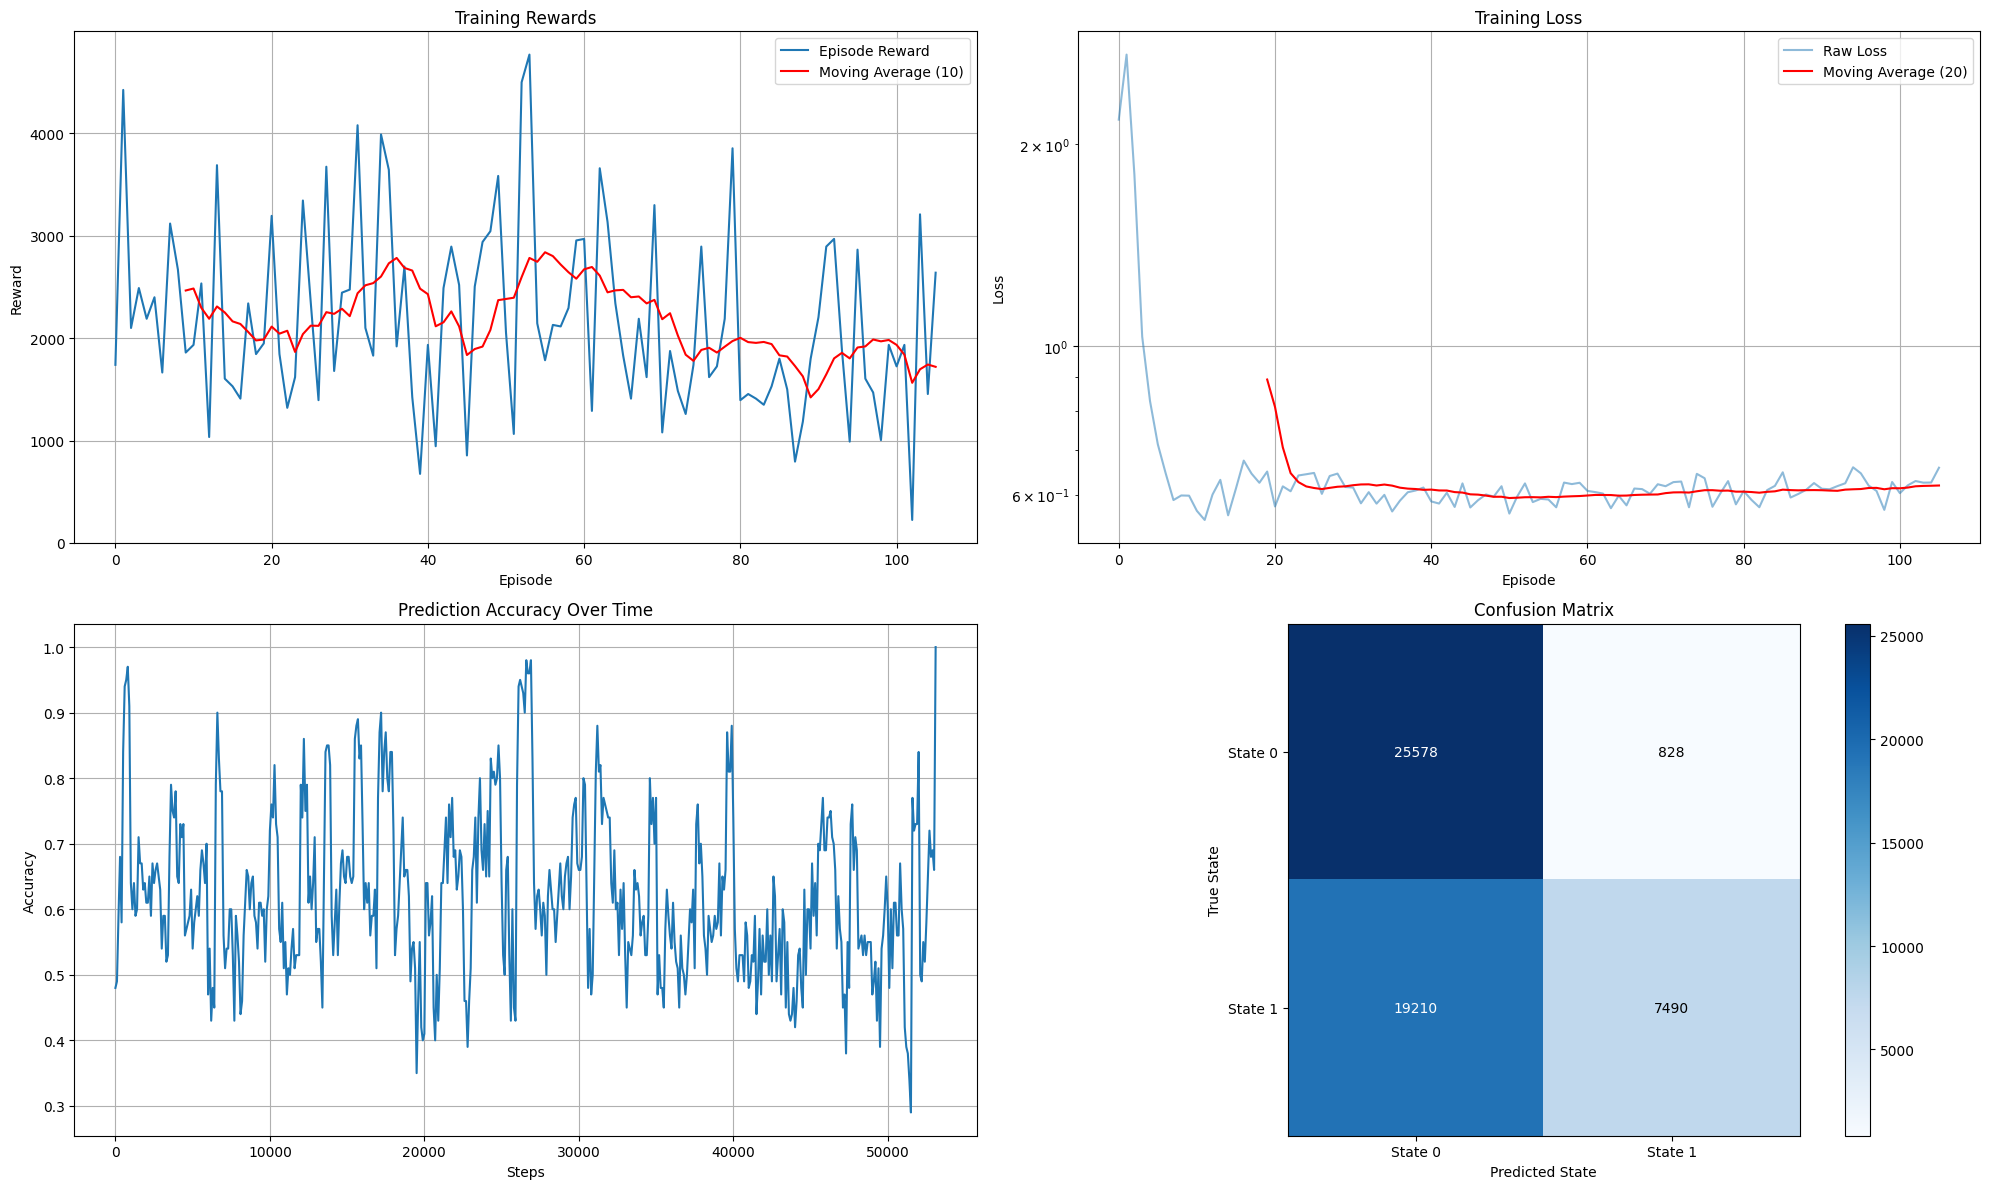


Evaluating on test environment...
Test episode 10/100 completed. Reward: 1605.00
Test episode 20/100 completed. Reward: 3315.00
Test episode 30/100 completed. Reward: 1770.00
Test episode 40/100 completed. Reward: 1455.00
Test episode 50/100 completed. Reward: 3000.00
Test episode 60/100 completed. Reward: 1815.00
Test episode 70/100 completed. Reward: 1530.00
Test episode 80/100 completed. Reward: 1650.00
Test episode 90/100 completed. Reward: 2865.00
Test episode 100/100 completed. Reward: 3030.00

Test Results Summary:
Average reward: 2288.70
Prediction accuracy: 0.6379
Predictions [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

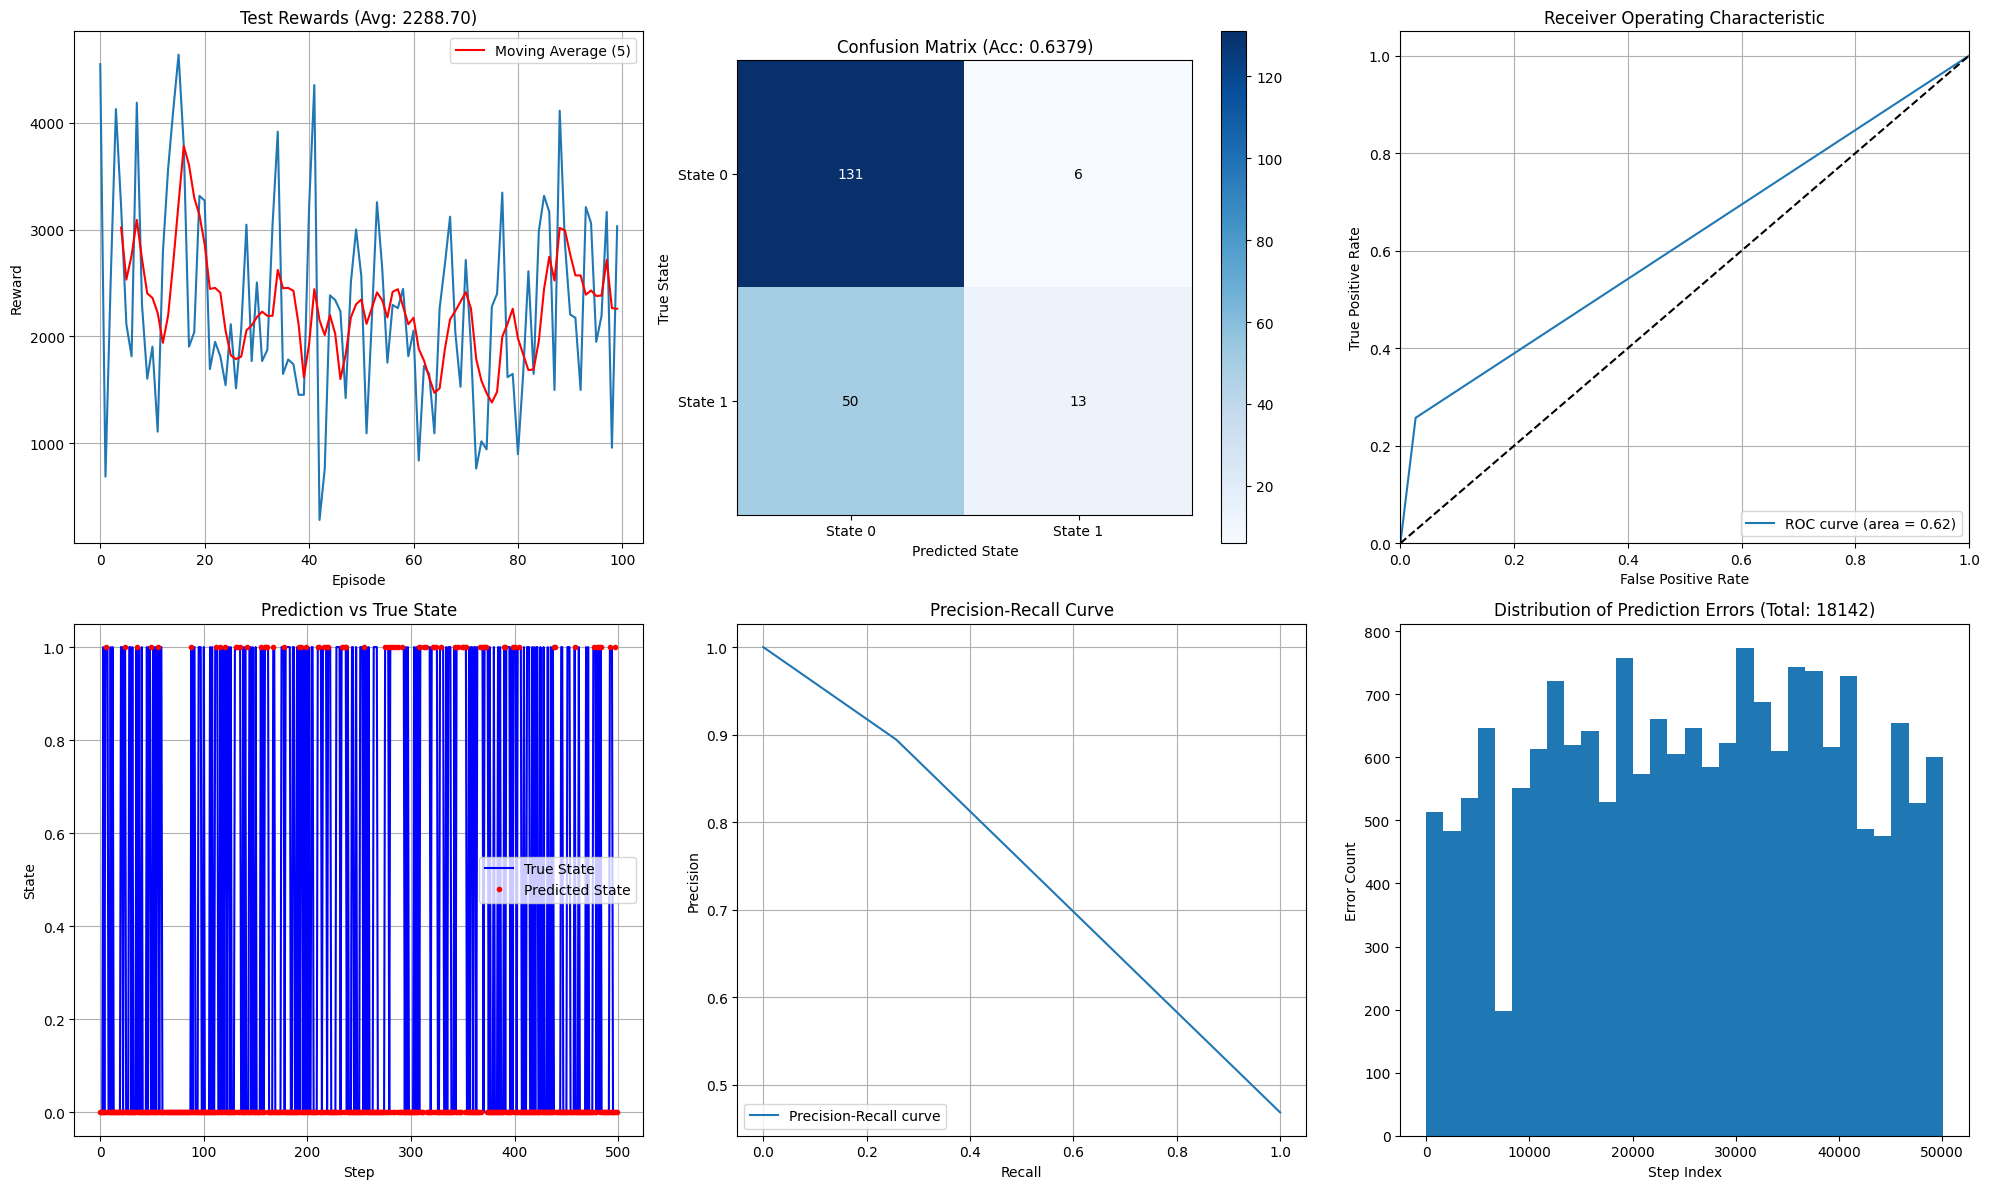


Training vs Test Performance:
Training accuracy: 0.6227
Test accuracy: 0.6379
Accuracy difference: 0.0152
Model generalizes well to the test environment.


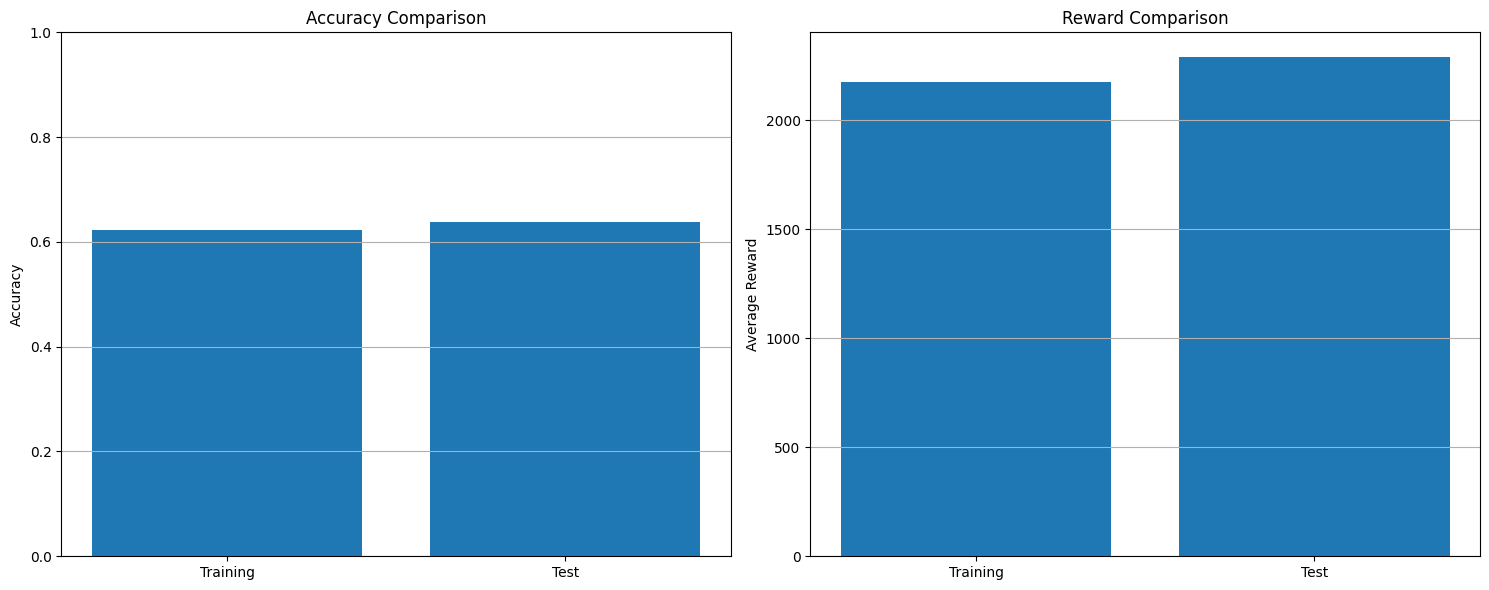

Dueling DQN experiment with separate testing completed!


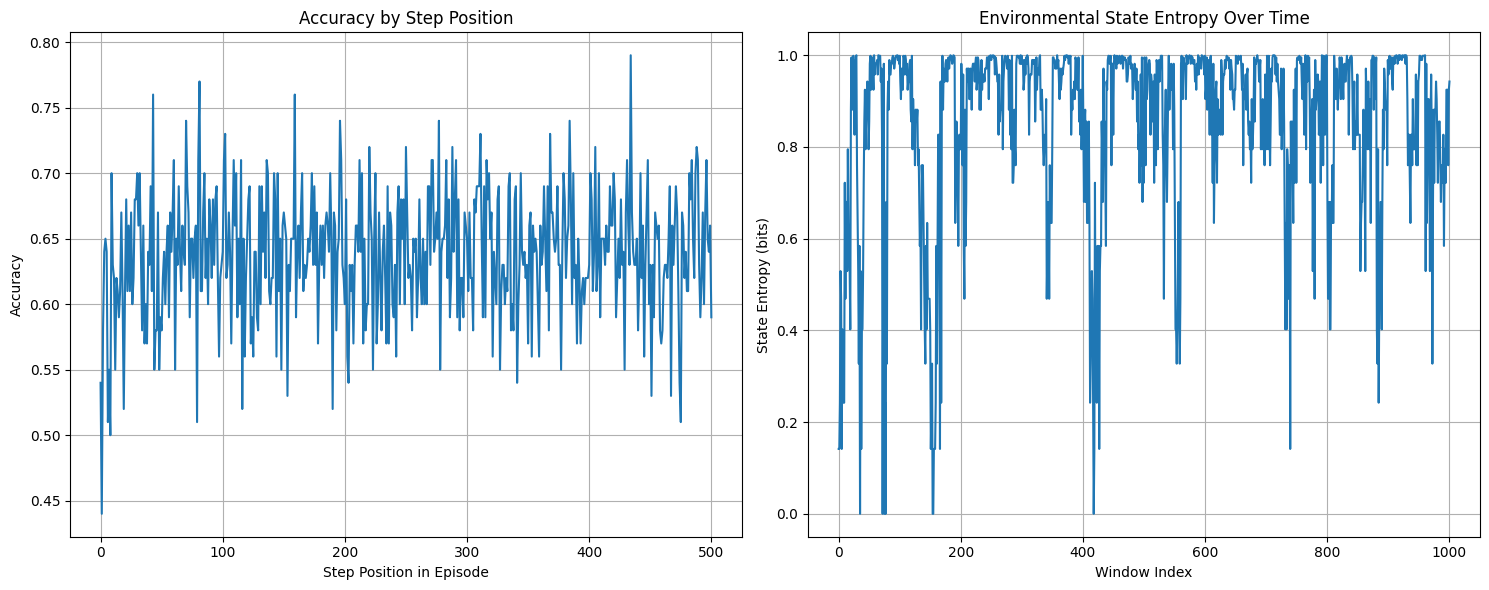


State Transition Analysis:
Transition 0 → 0: 16171 times (32.28%)
Transition 0 → 1: 10463 times (20.88%)
Transition 1 → 0: 10463 times (20.88%)
Transition 1 → 1: 13002 times (25.95%)


<module 'matplotlib.pyplot' from 'd:\\Projects\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [3]:
time_dependence = 1
trained_agent, train_results, test_results = run_dueling_dqn_experiment_with_testing(
        episodes=500,
        test_episodes=100
)
analyze_model_performance(train_results, test_results)

In [ ]:
time_dependence = 2
trained_agent, train_results, test_results = run_dueling_dqn_experiment_with_testing(
        episodes=500,
        test_episodes=100
)
analyze_model_performance(train_results, test_results)

d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Improved Dueling DQN:   2%|▏         | 10/500 [00:53<43:40,  5.35s/it]

Episode: 10, Reward: 2115.00, Avg Reward (last 10): 1798.50, Accuracy: 0.6148, Recent Loss: 0.678080, Epsilon: 0.0100
New best model saved! Avg reward: 1798.50


Training Improved Dueling DQN:   4%|▍         | 19/500 [01:45<48:00,  5.99s/it]

Episode: 20, Reward: 1800.00, Avg Reward (last 10): 1588.50, Accuracy: 0.5729, Recent Loss: 0.696050, Epsilon: 0.0100


Training Improved Dueling DQN:   4%|▍         | 20/500 [01:53<51:12,  6.40s/it]

Evaluation at episode 20: Reward = 2025.00


Training Improved Dueling DQN:   6%|▌         | 28/500 [02:42<49:13,  6.26s/it]

New best model saved! Avg reward: 1854.00


Training Improved Dueling DQN:   6%|▌         | 29/500 [02:48<49:13,  6.27s/it]

New best model saved! Avg reward: 1954.50


Training Improved Dueling DQN:   6%|▌         | 30/500 [02:55<50:48,  6.49s/it]

Episode: 30, Reward: 1770.00, Avg Reward (last 10): 1951.50, Accuracy: 0.5689, Recent Loss: 0.696341, Epsilon: 0.0100


Training Improved Dueling DQN:   6%|▌         | 31/500 [03:02<52:11,  6.68s/it]

New best model saved! Avg reward: 2122.50


Training Improved Dueling DQN:   6%|▋         | 32/500 [03:09<52:17,  6.70s/it]

New best model saved! Avg reward: 2124.00


Training Improved Dueling DQN:   7%|▋         | 33/500 [03:16<52:24,  6.73s/it]

New best model saved! Avg reward: 2218.50


Training Improved Dueling DQN:   8%|▊         | 39/500 [04:08<1:09:20,  9.02s/it]

Episode: 40, Reward: 3615.00, Avg Reward (last 10): 2088.00, Accuracy: 0.8144, Recent Loss: 0.676778, Epsilon: 0.0100


Training Improved Dueling DQN:   8%|▊         | 40/500 [04:17<1:10:35,  9.21s/it]

Evaluation at episode 40: Reward = 2670.00


Training Improved Dueling DQN:   9%|▊         | 43/500 [04:40<1:02:07,  8.16s/it]

New best model saved! Avg reward: 2247.00


Training Improved Dueling DQN:   9%|▉         | 44/500 [04:47<1:00:36,  7.97s/it]

New best model saved! Avg reward: 2391.00


Training Improved Dueling DQN:  10%|█         | 50/500 [05:38<1:01:36,  8.21s/it]

Episode: 50, Reward: 1485.00, Avg Reward (last 10): 1987.50, Accuracy: 0.5309, Recent Loss: 0.645899, Epsilon: 0.0100


Training Improved Dueling DQN:  12%|█▏        | 59/500 [07:01<1:11:13,  9.69s/it]

Episode: 60, Reward: 1215.00, Avg Reward (last 10): 1522.50, Accuracy: 0.4950, Recent Loss: 0.603986, Epsilon: 0.0100


Training Improved Dueling DQN:  12%|█▏        | 60/500 [07:22<1:35:58, 13.09s/it]

Evaluation at episode 60: Reward = 1335.00


Training Improved Dueling DQN:  14%|█▍        | 69/500 [09:41<1:49:02, 15.18s/it]

New best model saved! Avg reward: 2442.00


Training Improved Dueling DQN:  14%|█▍        | 70/500 [09:58<1:52:02, 15.63s/it]

Episode: 70, Reward: 2310.00, Avg Reward (last 10): 2551.50, Accuracy: 0.6407, Recent Loss: 0.625016, Epsilon: 0.0100
New best model saved! Avg reward: 2551.50


Training Improved Dueling DQN:  16%|█▌        | 79/500 [12:26<2:00:07, 17.12s/it]

Episode: 80, Reward: 1215.00, Avg Reward (last 10): 2016.00, Accuracy: 0.4950, Recent Loss: 0.669379, Epsilon: 0.0100


Training Improved Dueling DQN:  16%|█▌        | 80/500 [12:44<2:01:22, 17.34s/it]

Evaluation at episode 80: Reward = 1620.00


Training Improved Dueling DQN:  18%|█▊        | 90/500 [15:15<1:37:22, 14.25s/it]

Episode: 90, Reward: 1770.00, Avg Reward (last 10): 1855.50, Accuracy: 0.5689, Recent Loss: 0.589945, Epsilon: 0.0100


Training Improved Dueling DQN:  20%|█▉        | 99/500 [18:08<2:06:53, 18.99s/it]

Episode: 100, Reward: 2160.00, Avg Reward (last 10): 2007.00, Accuracy: 0.6208, Recent Loss: 0.639369, Epsilon: 0.0100


Training Improved Dueling DQN:  20%|██        | 100/500 [18:30<2:11:22, 19.71s/it]

Evaluation at episode 100: Reward = 1290.00


Training Improved Dueling DQN:  21%|██        | 105/500 [19:53<1:42:37, 15.59s/it]

In [ ]:
time_dependence = 3
trained_agent, train_results, test_results = run_dueling_dqn_experiment_with_testing(
        episodes=500,
        test_episodes=100
)
analyze_model_performance(train_results, test_results)

In [ ]:
time_dependence = 4
trained_agent, train_results, test_results = run_dueling_dqn_experiment_with_testing(
        episodes=500,
        test_episodes=100
)
analyze_model_performance(train_results, test_results)